In [1]:
import sys
sys.path.append('../')
import scPhyloX as spx
import numpy as np
import arviz as az
from tqdm import tqdm
import pandas as pd
from Bio import Phylo
import pickle
import argparse
from sko.DE import DE
from scipy.integrate import quad, solve_ivp
import pymc as pm
import pytensor
import pytensor.tensor as pt

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
import os
import pickle
from copy import deepcopy
from scipy.stats import poisson,mannwhitneyu, chisquare,linregress

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
plt.rcParams['pdf.fonttype']=42
plt.rcParams['font.size'] = 12

In [3]:
from scipy.integrate import solve_ivp

In [5]:
def para_inference_DE(data, T=20, c0=None, sigma=1, n_iter=100, bootstrape=0, verbose='text'):
    '''
    Mutation rate estimation using DE
    
    Args:
        data:
            lp-dist
        n_iter:
            Iterations of de estimation
        bootstrape:
            Weather using bootstrape to accuratly estimate mutation rate, 0 to turn off.
    Return:
        tuple:
            (accepted parameters, loss, de-estimator)
    '''
    if c0 is None:
        def loss(theta):
            ax, bx, r, k, t0, r1, b1, c0 = theta
            return -spx.est_haem.my_loglike((ax, bx, r, k, t0, r1, b1), data, (T, c0, sigma))
    else:
        def loss(theta):
            ax, bx, r, k, t0, r1, b1 = theta

            return -spx.est_haem.my_loglike((ax, bx, r, k, t0, r1, b1), data, (T, c0, sigma)) 
    
    def run1():
        constraint_ueq = [lambda x: x[0]+x[1]-2]
        if c0 is None:
            de = DE(func=loss, n_dim=8, max_iter=n_iter, lb=[0, 0.999, 0, 0, 0, 0, 0, 1], ub=[2, 1.001, 3, 3, T, 1, 1, 2000], constraint_ueq=constraint_ueq)
        else:
            de = DE(func=loss, n_dim=7, max_iter=n_iter, lb=[0, 0, 0, 0, 0, 0, 0], ub=[2, 2, 3, 5, T, 1, 1], constraint_ueq=constraint_ueq)
        bestx, besty = [], []
        for i in range(n_iter):
            xt,yt = de.run(1)
            bestx.append(xt)
            besty.append(yt)
            if verbose == 'text':
                print(f'\riter{i}, loss:{yt}, est={xt}',end = "")
            elif verbose == 'warning':
                warnings.warn(f'\riter{i}, loss:{yt}, est={xt}', Warning)
        return bestx, besty, de
    if bootstrape:
        ress_x, ress_y, des = [], [], []
        for _ in range(bootstrape):
            res_x, res_y, de = run1()
            ress_x.append(res_x)
            ress_y.append(res_y)
            des.append(de) 
        return np.array(ress_x), np.array(ress_y), des
    else:
        return run1()

In [138]:
ages = {'AX001':63, 'KX001':29, 'KX002':38, 'KX003':81, 'KX004':77, 'KX007':75, 'KX008':76, 'SX001':48}
for file in os.listdir('../datasets/HSC_lifespan'):
# for file in ['filtering_output_KX001']:
    if file[0] != 'f':
        continue
    donor = file.split('_')[-1]
    tree_file = os.listdir(f'../datasets/HSC_lifespan/{file}')[0]
    tree = Phylo.read(f'../datasets/HSC_lifespan/{file}/{tree_file}', format='newick')
    T = ages[donor]
    mutnum = []
    tree_dep = tree.depths() 
    for i in tree.get_terminals():
        mutnum.append(tree_dep[i])

    ge = spx.est_mr.GenerationEst(mutnum, 17)
    gen_num = ge.estimate(1e5)
    res = para_inference_DE(gen_num, T=T, sigma=1000, n_iter=50, bootstrape=0)
    pickle.dump(res[:2], open(f"../results/hsc/{donor}_de.pkl", 'wb'))
    axh, bxh, rh, kh, t0h, r1h, b1h, c0 = res[0][-1]
    theta_h = [axh, bxh, rh, kh, t0h, r1h, b1h]
    
    logl = spx.est_haem.LogLike(spx.est_haem.my_loglike, gen_num, (T, c0, 1000))
    with pm.Model() as model:
        ax = pm.TruncatedNormal('ax', mu=axh, sigma=0.1, lower=0, upper=2, initval=axh)
        # bx = pm.TruncatedNormal('bx', mu=bxh, sigma=0.1, lower=0, upper=2, initval=bxh)
        r = pm.TruncatedNormal('r', mu=rh, sigma=0.1, lower=0.1, initval=rh)
        k = pm.TruncatedNormal('k', mu=kh, sigma=0.1, lower=0, upper=5, initval=kh)
        t0 = pm.TruncatedNormal('t0', mu=t0h, sigma=0.3, lower=0, upper=20, initval=t0h)
        r1 = pm.TruncatedNormal('r1', mu=r1h, sigma=0.1, lower=0.1, initval=r1h)
        b1 = pm.Beta('b1', alpha=1, beta=1/b1h-1, initval=b1h)

        theta = pt.as_tensor_variable([ax, 1, r, k, t0, r1, b1])
        pm.Potential("likelihood", logl(theta))
        idata = pm.sample(1000, tune=1000, step=pm.DEMetropolis(), chains=8)
        
    pickle.dump(idata, open(f"../results/hsc/{donor}.pkl", 'wb'))

iter0, loss:[712.06137368], est=[1.46391424e-01 1.00032539e+00 7.33477069e-01 4.41185982e-01
iter1, loss:[712.06137368], est=[1.46391424e-01 1.00032539e+00 7.33477069e-01 4.41185982e-01
iter2, loss:[694.35976898], est=[7.70620662e-01 9.99303960e-01 8.60326957e-01 2.05450110e+00
iter3, loss:[694.35976898], est=[7.70620662e-01 9.99303960e-01 8.60326957e-01 2.05450110e+00
iter4, loss:[694.35976898], est=[7.70620662e-01 9.99303960e-01 8.60326957e-01 2.05450110e+00
iter5, loss:[694.35976898], est=[7.70620662e-01 9.99303960e-01 8.60326957e-01 2.05450110e+00
iter6, loss:[694.35976898], est=[7.70620662e-01 9.99303960e-01 8.60326957e-01 2.05450110e+00
iter7, loss:[694.35976898], est=[7.70620662e-01 9.99303960e-01 8.60326957e-01 2.05450110e+00
iter8, loss:[694.35976898], est=[7.70620662e-01 9.99303960e-01 8.60326957e-01 2.05450110e+00
iter9, loss:[694.35976898], est=[7.70620662e-01 9.99303960e-01 8.60326957e-01 2.05450110e+00
iter10, loss:[694.35976898], est=[7.70620662e-01 9.99303960e-01 8.6032

Population sampling (8 chains)
DEMetropolis: [ax, r, k, t0, r1, b1]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1969 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


iter0, loss:[561.77296544], est=[5.82450412e-01 1.00041848e+00 5.80310194e-01 2.11349028e-01
iter1, loss:[561.77296544], est=[5.82450412e-01 1.00041848e+00 5.80310194e-01 2.11349028e-01
iter2, loss:[537.40892103], est=[6.73691595e-01 1.00021756e+00 9.52344108e-01 2.02595704e+00
iter3, loss:[512.87465409], est=[1.13833396e-02 1.00005788e+00 1.63434081e+00 1.74553693e+00
iter4, loss:[512.87465409], est=[1.13833396e-02 1.00005788e+00 1.63434081e+00 1.74553693e+00
iter5, loss:[389.46514941], est=[5.02224983e-01 9.99559057e-01 6.73807399e-01 2.81639743e+00
iter6, loss:[389.46514941], est=[5.02224983e-01 9.99559057e-01 6.73807399e-01 2.81639743e+00
iter7, loss:[389.46514941], est=[5.02224983e-01 9.99559057e-01 6.73807399e-01 2.81639743e+00
iter8, loss:[389.46514941], est=[5.02224983e-01 9.99559057e-01 6.73807399e-01 2.81639743e+00
iter9, loss:[387.86044277], est=[5.02224983e-01 9.99559057e-01 6.73807399e-01 2.81639743e+00
iter10, loss:[387.86044277], est=[5.02224983e-01 9.99559057e-01 6.7380

Population sampling (8 chains)
DEMetropolis: [ax, r, k, t0, r1, b1]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 965 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


iter0, loss:[595.66943506], est=[6.74091085e-02 1.00053976e+00 1.82398337e+00 2.11097648e+00
iter1, loss:[595.66943506], est=[6.74091085e-02 1.00053976e+00 1.82398337e+00 2.11097648e+00
iter2, loss:[541.27039154], est=[2.06303383e-01 1.00004587e+00 8.20269044e-01 7.95334673e-01
iter3, loss:[541.27039154], est=[2.06303383e-01 1.00004587e+00 8.20269044e-01 7.95334673e-01
iter4, loss:[541.27039154], est=[2.06303383e-01 1.00004587e+00 8.20269044e-01 7.95334673e-01
iter5, loss:[541.27039154], est=[2.06303383e-01 1.00004587e+00 8.20269044e-01 7.95334673e-01
iter6, loss:[541.27039154], est=[2.06303383e-01 1.00004587e+00 8.20269044e-01 7.95334673e-01
iter7, loss:[462.05522223], est=[  0.48000232   0.99908521   0.20637335   0.38483353  12.46975302
iter8, loss:[458.69387071], est=[  0.48000232   0.99922531   0.20637335   0.38483353  11.11901367
iter9, loss:[458.69387071], est=[  0.48000232   0.99922531   0.20637335   0.38483353  11.11901367
iter10, loss:[458.69387071], est=[  0.48000232   0.9992

Population sampling (8 chains)
DEMetropolis: [ax, r, k, t0, r1, b1]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1106 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


iter0, loss:[1015.08966374], est=[3.54246690e-02 9.99207091e-01 6.66682749e-01 2.20648201e+00
iter1, loss:[1015.08966374], est=[3.54246690e-02 9.99207091e-01 6.66682749e-01 2.20648201e+00
iter2, loss:[1015.08966374], est=[3.54246690e-02 9.99207091e-01 6.66682749e-01 2.20648201e+00
iter3, loss:[1015.08966374], est=[3.54246690e-02 9.99207091e-01 6.66682749e-01 1.89158339e+00
iter4, loss:[1015.05775152], est=[3.54246690e-02 9.99207091e-01 6.66682749e-01 1.89158339e+00
iter5, loss:[1015.05775152], est=[3.54246690e-02 9.99207091e-01 6.66682749e-01 1.89158339e+00
iter6, loss:[979.42420514], est=[3.19789779e-01 1.00040171e+00 2.05328561e+00 1.05280684e+00
iter7, loss:[946.0960434], est=[3.54246690e-02 9.99207091e-01 2.88583320e+00 6.53955452e-01
iter8, loss:[828.19773325], est=[4.52895645e-01 1.00055675e+00 1.00002754e+00 1.38513718e+00
iter9, loss:[828.19773325], est=[4.52895645e-01 1.00055675e+00 1.00002754e+00 1.38513718e+00
iter10, loss:[828.19773325], est=[4.52895645e-01 1.00055675e+00 1

Population sampling (8 chains)
DEMetropolis: [ax, r, k, t0, r1, b1]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 21228 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


iter0, loss:[913.04586836], est=[2.43912626e-01 1.00036152e+00 7.73648449e-01 3.01321133e-01
iter1, loss:[805.77037787], est=[2.90849641e-02 1.00017887e+00 9.39991932e-01 1.68370433e+00
iter2, loss:[805.77037787], est=[2.90849641e-02 1.00017887e+00 9.39991932e-01 1.68370433e+00
iter3, loss:[805.77037787], est=[2.90849641e-02 1.00017887e+00 9.39991932e-01 1.68370433e+00
iter4, loss:[805.77037787], est=[2.90849641e-02 1.00017887e+00 9.39991932e-01 1.68370433e+00
iter5, loss:[805.77037787], est=[2.90849641e-02 1.00017887e+00 9.39991932e-01 1.68370433e+00
iter6, loss:[803.09725071], est=[2.90849641e-02 1.00017887e+00 9.39991932e-01 1.68370433e+00
iter7, loss:[803.09725071], est=[2.90849641e-02 1.00017887e+00 9.39991932e-01 1.68370433e+00
iter8, loss:[803.09725071], est=[2.90849641e-02 1.00017887e+00 9.39991932e-01 1.68370433e+00
iter9, loss:[803.09725071], est=[2.90849641e-02 1.00017887e+00 9.39991932e-01 1.68370433e+00
iter10, loss:[803.09725071], est=[2.90849641e-02 1.00017887e+00 9.3999

Population sampling (8 chains)
DEMetropolis: [ax, r, k, t0, r1, b1]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 2439 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


iter0, loss:[812.05389805], est=[  0.25529987   0.99928594   1.19601822   2.52976815  11.9653645
iter1, loss:[812.05389805], est=[  0.25529987   0.99928594   1.19601822   2.52976815  11.9653645
iter2, loss:[812.05389805], est=[  0.25529987   0.99928594   1.19601822   2.52976815  11.9653645
iter3, loss:[812.05389805], est=[  0.25529987   0.99928594   1.19601822   2.52976815  11.9653645
iter4, loss:[812.05389805], est=[  0.25529987   0.99928594   1.19601822   2.52976815  11.9653645
iter5, loss:[812.05389805], est=[  0.25529987   0.99928594   1.19601822   2.52976815  11.9653645
iter6, loss:[774.89799298], est=[ 0.14693179  0.99968134  1.3265805   0.404203   17.78367598  0.59709856
iter7, loss:[774.89799298], est=[ 0.14693179  0.99968134  1.3265805   0.404203   17.78367598  0.59709856
iter8, loss:[774.89799298], est=[ 0.14693179  0.99968134  1.3265805   0.404203   17.78367598  0.59709856
iter9, loss:[774.89799298], est=[ 0.14693179  0.99968134  1.3265805   0.404203   17.78367598  0.5970985

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'ax_interval__': array(-3.91330052), 'r_interval__': array(-0.19411382), 'k_interval__': array(-0.7919767), 't0_interval__': array(nan), 'r1_interval__': array(-0.10600748), 'b1_logodds__': array(-0.03705304)}

Logp initial evaluation results:
{'ax': -1.45, 'r': 1.19, 'k': 1.45, 't0': nan, 'r1': 1.28, 'b1': -1.38, 'likelihood': nan}
You can call `model.debug()` for more details.

In [5]:
ages = {'AX001':63, 'KX001':29, 'KX002':38, 'KX003':81, 'KX004':77, 'KX007':75, 'KX008':76, 'SX001':48}
colors1 = ['#ff6a00', '#ff812b', '#ff9645', '#ffa95c', '#ffbc73', '#ffcd88', '#ffde9e', '#ffefb3'][::-1]
colors2 = ['#686eab', '#787cb5', '#898cc0', '#999bca', '#a9abd5', '#b9bbdf', '#cacbea', '#dadcf4'][::-1]
cmp1 = dict(zip(np.array(list(ages.keys()))[np.argsort(list(ages.values()))], colors1))
cmp2 = dict(zip(np.array(list(ages.keys()))[np.argsort(list(ages.values()))], colors2))

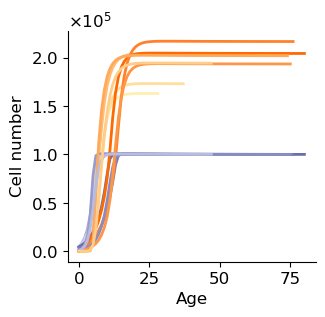

In [160]:
fig, ax = plt.subplots(figsize=(3.2,3))
for i in ages.keys():
    # if i in ['KX001']:
    #     continue
    res = pickle.load(open(f'../results/hsc/{i}.pkl', 'rb'))
    summary = az.summary(res)
    theta_mu = summary.loc['ax,r,k,t0,r1,b1'.split(',')]['mean'].to_numpy().tolist()
    theta_sd = summary.loc['ax,r,k,t0,r1,b1'.split(',')]['sd'].to_numpy().tolist()
    theta_h = deepcopy(theta_mu)
    theta_h.insert(1,1)
    c0 = 100
    T = ages[i]
    n_cyclingcells = np.array([[spx.est_haem.stem_num(i, j, c0, *theta_h) for j in range(T)] for i in range(120)])
    n_noncyclingcells = solve_ivp(spx.est_haem.nstem_num, t_span=(0, T), t_eval=range(0,T), y0=[0]*120, method='RK45', args=(c0, *theta_h)).y
    scale = 1e5/n_cyclingcells.sum(0)[-1]
    ax.plot(n_cyclingcells.sum(0)*scale, c=cmp2[i], lw=2, label=i.split('_')[0])
    ax.plot(n_noncyclingcells.sum(0)*scale, c=cmp1[i], lw=2)
lgnds=[]
for i in cmp1.keys():
    lgnds.append(mlines.Line2D([], [], color=cmp1[i],lw=1 ,label=f'{ages[i]}-year-old_HSC'))
for i in cmp2.keys():
    lgnds.append(mlines.Line2D([], [], color=cmp2[i],lw=1 ,label=f'{ages[i]}-year-old_MPP'))
ax.set_xlabel('Age')
ax.set_ylabel('Cell number')
ax.ticklabel_format(style='sci', scilimits= (-1,2), axis='y',useMathText=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# lgnd = ax.legend(handles=lgnds, ncol=2, bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0) 
plt.savefig('../results/figs/hsc_growth_reg.pdf')

In [6]:
para_df = pd.DataFrame(columns='ax,r,k,t0,r1,b1'.split(','))
for i in ages.keys():
    res = pickle.load(open(f'../results/hsc/{i}.pkl', 'rb'))
    summary = az.summary(res)
    theta_mu = summary.loc['ax,r,k,t0,r1,b1'.split(',')]['mean'].to_numpy().tolist()
    para_df.loc[i.split('.')[0]] = theta_mu
para_df['age'] = [ages[i] for i in para_df.index]


colless_ind = []
for i in para_df.index:
    file_name = os.listdir(f"../datasets/HSC_lifespan/filtering_output_{i}")[0]
    tree = Phylo.read(f"../datasets/HSC_lifespan/filtering_output_{i}/{file_name}", format='newick')
    colless_ind.append(np.mean(spx.utils.colless_index(tree)))
para_df['colless_index'] = colless_ind

sc_frac = []
for i in para_df.index:
    res = pickle.load(open(f'../results/hsc/{i}.pkl', 'rb'))
    summary = az.summary(res)
    theta_mu = summary.loc['ax,r,k,t0,r1,b1'.split(',')]['mean'].to_numpy().tolist()
    theta_h = deepcopy(theta_mu)
    theta_h.insert(1,1)
    
    c0 = 1e5
    T = ages[i]
    n_cyclingcells = np.array([[spx.est_haem.stem_num(i, j, c0, *theta_h) for j in range(T)] for i in range(120)])
    n_noncyclingcells = solve_ivp(spx.est_haem.nstem_num, t_span=(0, T), t_eval=range(0,T), y0=[0]*120, method='RK45', args=(c0, *theta_h)).y
    sc_frac.append(n_cyclingcells[:, -1].sum() / (n_noncyclingcells[:, -1].sum()+n_cyclingcells[:, -1].sum()))
para_df['sc_frac'] = sc_frac

/home/wangkun/miniconda3/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


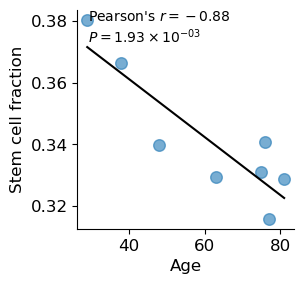

In [21]:
fig, ax = plt.subplots(figsize=(3.2,3))
spx.utils.corr_plot(para_df['age'], para_df['sc_frac'], ax=ax, stats='pearson', line='fit', alternative='less')
ax.set_ylabel('Stem cell fraction')
ax.set_xlabel('Age')
plt.tight_layout()
plt.savefig('../results/figs/sc_age_corr.pdf')

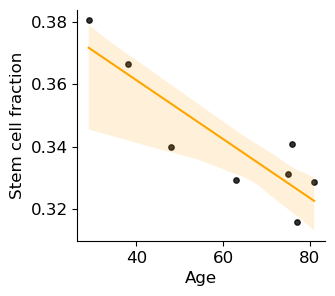

In [11]:
fig, ax = plt.subplots(figsize=(3.2,3))
# spx.utils.corr_plot(paras_df['colless_index_corrected'], paras_df['adv_frac'], ax=ax, stats='spearmanr', alternative='greater')
sns.regplot(x=para_df['age'], y=para_df['sc_frac'], ax=ax, n_boot=100, ci=95,
            line_kws={"color": 'orange', "linewidth": 1.5},
            scatter_kws={"color":'black','s':15}
           )
ax.set_ylabel('Stem cell fraction')
ax.set_xlabel('Age')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('../results/new/age_scf.pdf')

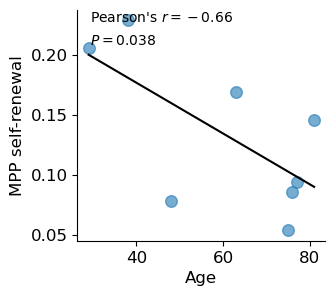

In [23]:
fig, ax = plt.subplots(figsize=(3.2,3))
spx.utils.corr_plot(para_df['age'], para_df['b1'], ax=ax, stats='pearson', line='fit', alternative='less')
ax.set_ylabel('MPP self-renewal')
ax.set_xlabel('Age')
plt.savefig('../results/figs/mpp_age_corr.pdf', bbox_inches='tight')

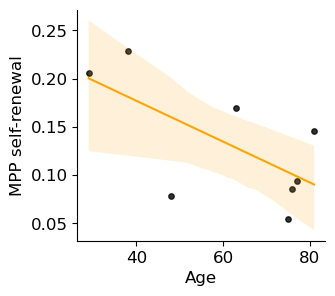

In [20]:
fig, ax = plt.subplots(figsize=(3.2,3))
sns.regplot(x=para_df['age'], y=para_df['b1'], ax=ax, n_boot=100, ci=95,
            line_kws={"color": 'orange', "linewidth": 1.5},
            scatter_kws={"color":'black','s':15}
           )
ax.set_ylabel('MPP self-renewal')
ax.set_xlabel('Age')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('../results/new/age_ms.pdf')

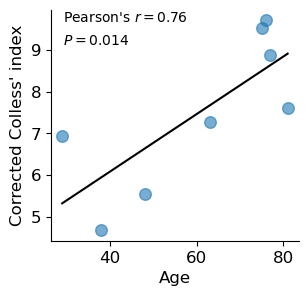

In [125]:
fig, ax = plt.subplots(figsize=(3.2,3))
spx.utils.corr_plot(para_df['age'], para_df['colless_index'], ax=ax, stats='pearson', line='fit', alternative='greater')
ax.set_ylabel('Corrected Colless\' index')
ax.set_xlabel('Age')
plt.savefig('../results/figs/ci_age_corr.pdf')

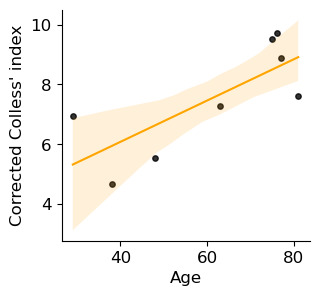

In [21]:
fig, ax = plt.subplots(figsize=(3.2,3))
sns.regplot(x=para_df['age'], y=para_df['colless_index'], ax=ax, n_boot=100, ci=95,
            line_kws={"color": 'orange', "linewidth": 1.5},
            scatter_kws={"color":'black','s':15}
           )
ax.set_ylabel('Corrected Colless\' index')
ax.set_xlabel('Age')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('../results/new/age_cci.pdf')

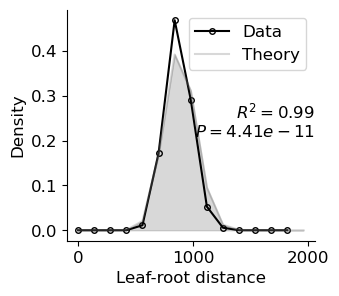

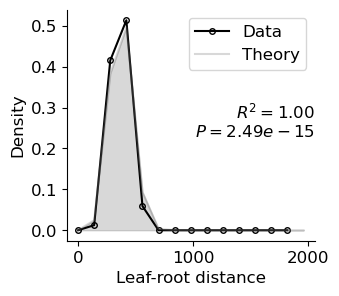

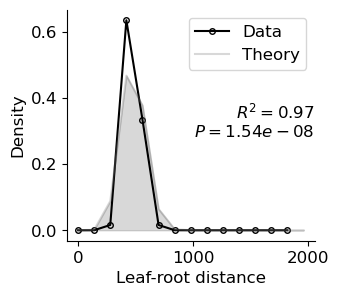

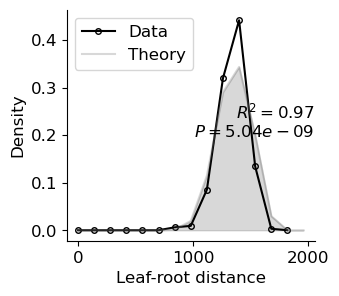

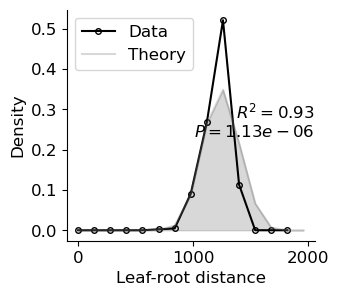

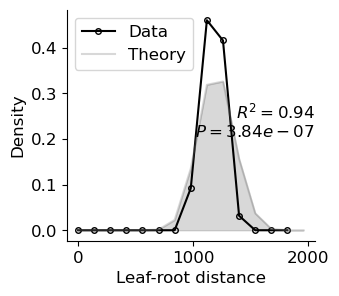

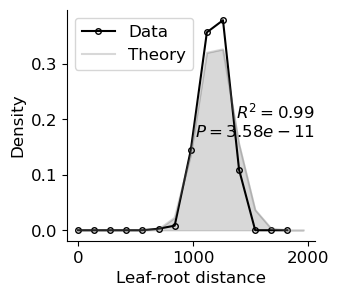

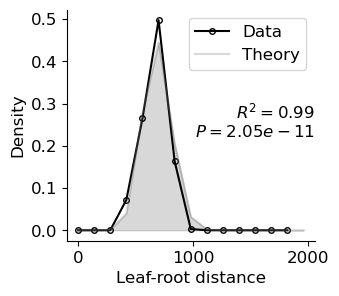

In [33]:
for donor in ages.keys():
    file_name = os.listdir(f"../datasets/HSC_lifespan/filtering_output_{donor}")[0]
    
    tree = Phylo.read(f"../datasets/HSC_lifespan/filtering_output_{donor}/{file_name}", format='newick')
    tree_dep = tree.depths() 
    mutnum = []
    for ce in tree.get_terminals():
        mutnum.append(tree_dep[ce])
        
    res = pickle.load(open(f'../results/hsc/{donor}.pkl', 'rb'))
    summary = az.summary(res)
    theta_mu = summary.loc['ax,r,k,t0,r1,b1'.split(',')]['mean'].to_numpy().tolist()
    theta_sd = summary.loc['ax,r,k,t0,r1,b1'.split(',')]['sd'].to_numpy().tolist()
    theta_h = deepcopy(theta_mu)
    theta_h.insert(1,1)
    c0 = 100
    T = ages[donor]
    nsc = np.array([[spx.est_haem.stem_num(i, j, 100, *theta_h) for j in range(T)] for i in range(100)])
    nnc = solve_ivp(spx.est_haem.nstem_num, t_span=(0, T), y0=[0]*100, method='RK45', args=(100, *theta_h)).y[:,-1]
    
    fig, ax = plt.subplots(1, 1, figsize=(3.2, 3))

    alpha = nsc[:,-1]+nnc
    alpha = alpha / sum(alpha)
    max_val = 2100
    n_hist = 15
    mutdist = np.histogram(mutnum, np.arange(0, max_val, int(max_val/n_hist)))
    th_dist = np.zeros(max_val)
    for i, a in enumerate(alpha):
        th_dist = th_dist + a*poisson((i+1)*17).pmf(range(max_val))
    th_dist_x = []
    th_dist_y = []
    for i in range(n_hist):
        th_dist_x.append(i*int(max_val/n_hist))
        th_dist_y.append(np.sum(th_dist[i*int(max_val/n_hist):(i+1)*int(max_val/n_hist)]))
    ax.plot(mutdist[1][:-1], mutdist[0]/sum(mutdist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
    ax.plot(th_dist_x, th_dist_y, c='tab:grey',alpha=0.3, label='Theory')
    ax.fill_between(th_dist_x, th_dist_y, color='tab:grey', alpha=0.3)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Leaf-root distance')
    ax.set_ylabel('Density')
    ax.legend() 
    try:
        reg = linregress(mutdist[0], th_dist_y[:-1])
    except:
        reg = linregress(mutdist[0], th_dist_y)
    ax.text(ax.get_xlim()[1], ax.get_ylim()[1]/2, f'$R^2={{{reg.rvalue:.2f}}}$''\n'f'$P={{{reg.pvalue:.2e}}}$', ha='right', va='center')
    # print(f'{donor}:{chisquare(f_obs = mutdist[0]/sum(mutdist[0]), f_exp=th_dist_y[:-1]/sum(th_dist_y[:-1]), ddof=4)}')
    plt.savefig(f'../results/figs/lr_dist_{donor}.pdf')

In [44]:
plt.rcParams['font.size'] = 24

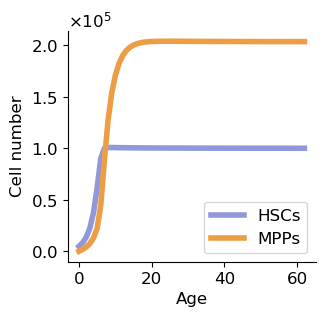

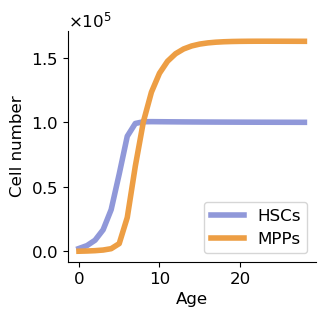

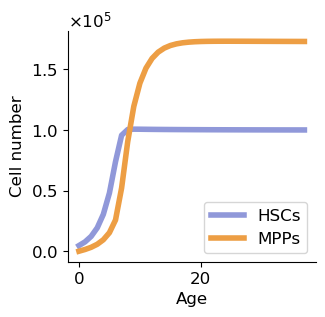

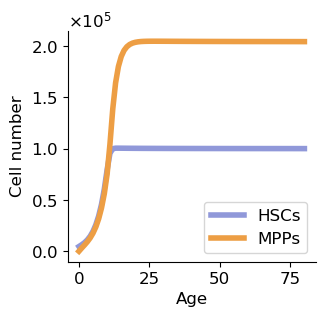

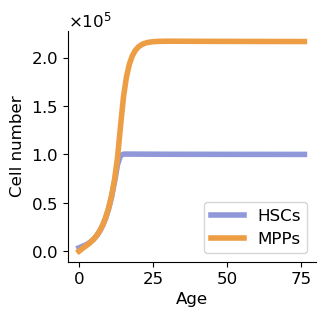

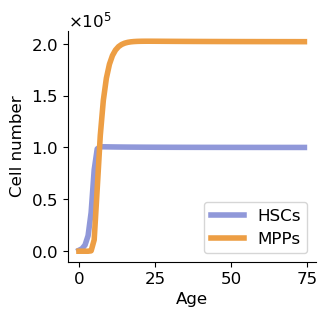

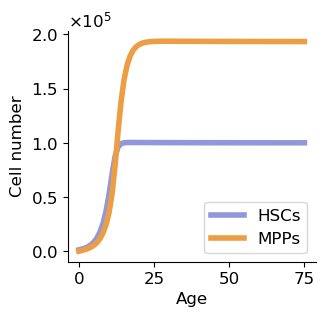

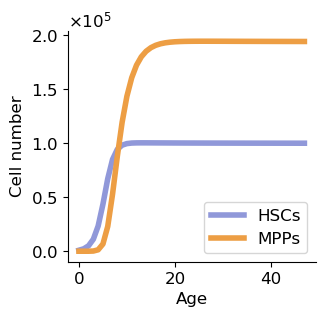

In [156]:
for donor in ages.keys():
    fig, ax = plt.subplots(1, 1, figsize=(3.2,3))
    res = pickle.load(open(f'../results/hsc/{donor}.pkl', 'rb'))
    summary = az.summary(res)
    theta_mu = summary.loc['ax,r,k,t0,r1,b1'.split(',')]['mean'].to_numpy().tolist()
    theta_sd = summary.loc['ax,r,k,t0,r1,b1'.split(',')]['sd'].to_numpy().tolist()
    theta_h = deepcopy(theta_mu)
    theta_h.insert(1,1)
    
    c0 = 1e5
    T = ages[donor]
    n_cyclingcells = np.array([[spx.est_haem.stem_num(i, j, c0, *theta_h) for j in range(T)] for i in range(120)])
    n_noncyclingcells = solve_ivp(spx.est_haem.nstem_num, t_span=(0, T), t_eval=range(0,T), y0=[0]*120, method='RK45', args=(c0, *theta_h)).y
    scale = 1e5/n_cyclingcells.sum(0)[-1]

    ax.plot(n_cyclingcells.sum(0)*scale, c='#9098d9', lw=4, label='HSCs')
    ax.plot(n_noncyclingcells.sum(0)*scale, c='#ed9e44', lw=4, label='MPPs')
    # axes.set_title(f'{fly} {organ}')
    ax.set_xlabel('Age')
    ax.set_ylabel('Cell number')
    ax.ticklabel_format(style='sci', scilimits= (-1,2), axis='y',useMathText=True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc=4)
    # print(donor)
    plt.savefig(f'../results/figs/cell_number_{donor}.pdf')

In [35]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ax,0.614,0.050,0.527,0.704,0.004,0.003,126.0,142.0,1.06
r,0.838,0.010,0.818,0.854,0.001,0.001,171.0,291.0,1.04
k,2.778,0.093,2.609,2.950,0.007,0.005,200.0,357.0,1.04
t0,5.945,0.271,5.403,6.420,0.019,0.013,206.0,349.0,1.03
r1,0.622,0.081,0.483,0.787,0.006,0.004,206.0,244.0,1.03
b1,0.169,0.088,0.021,0.321,0.008,0.006,104.0,100.0,1.06


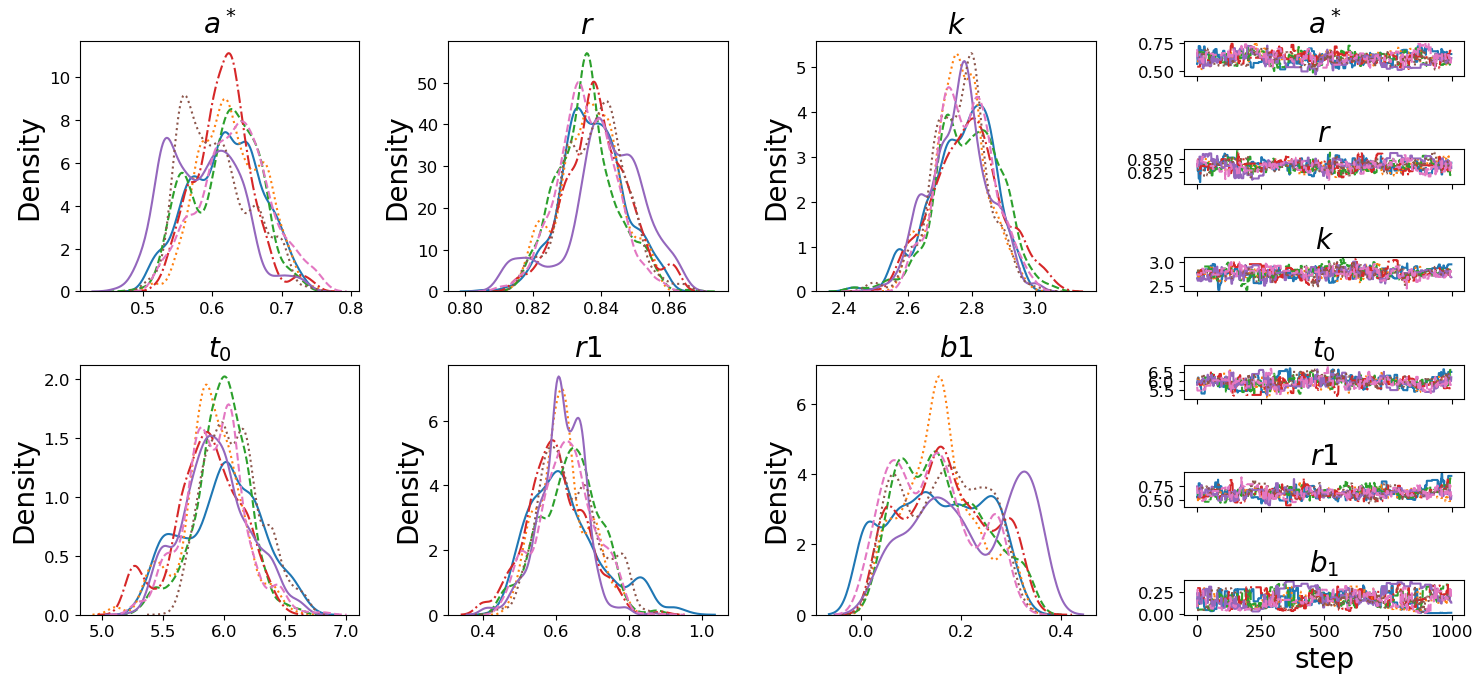

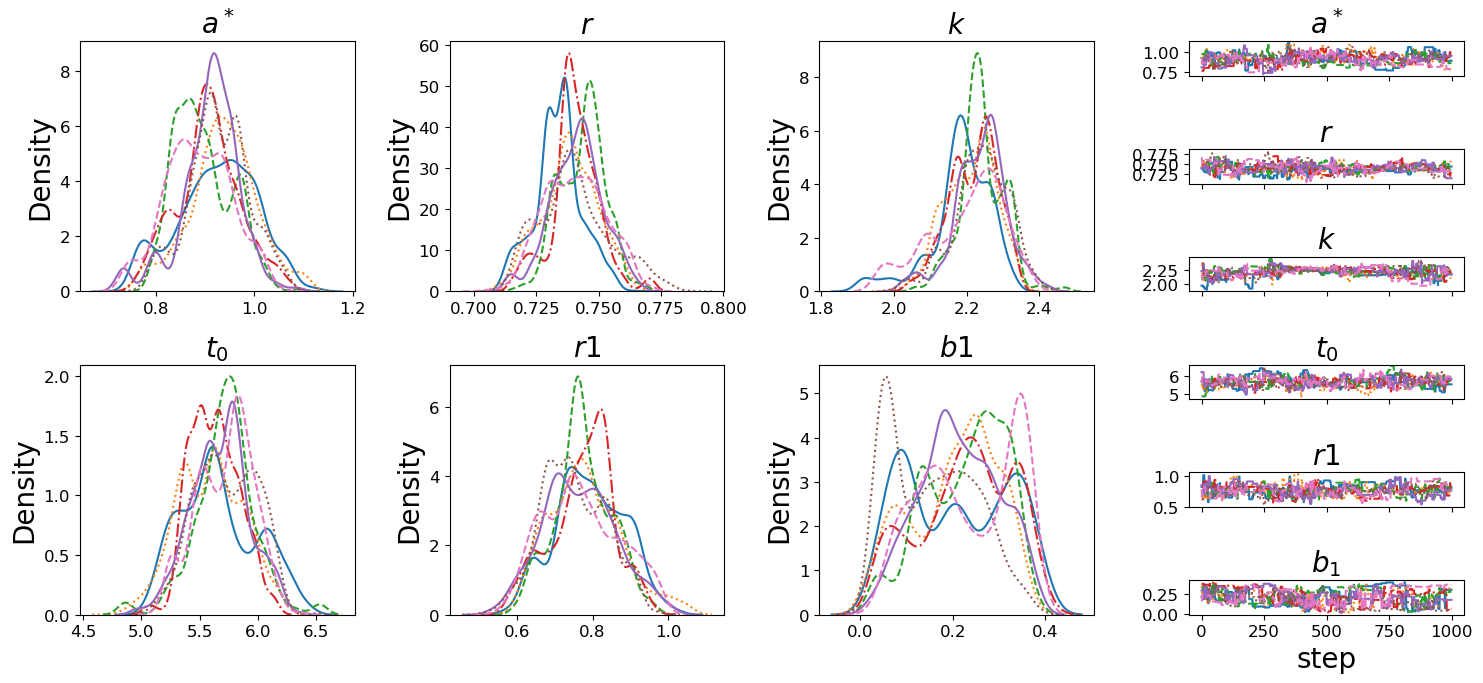

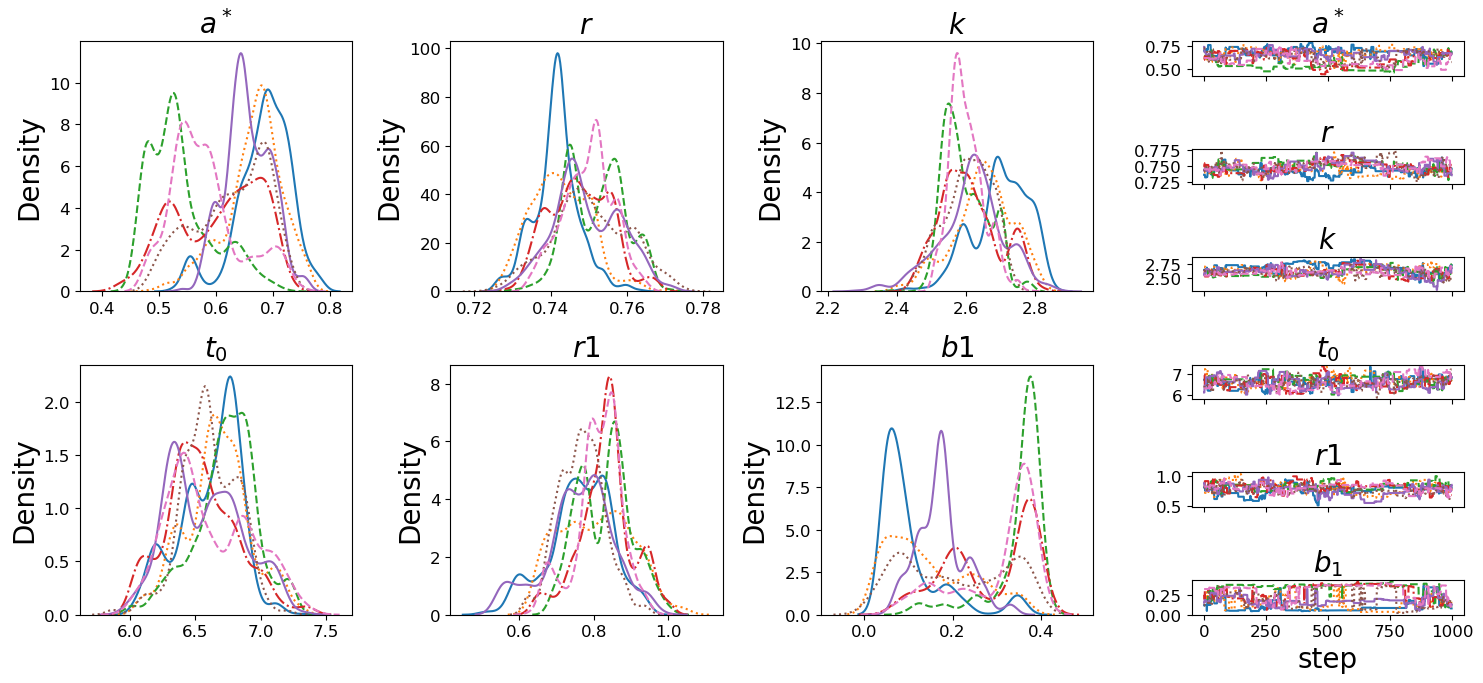

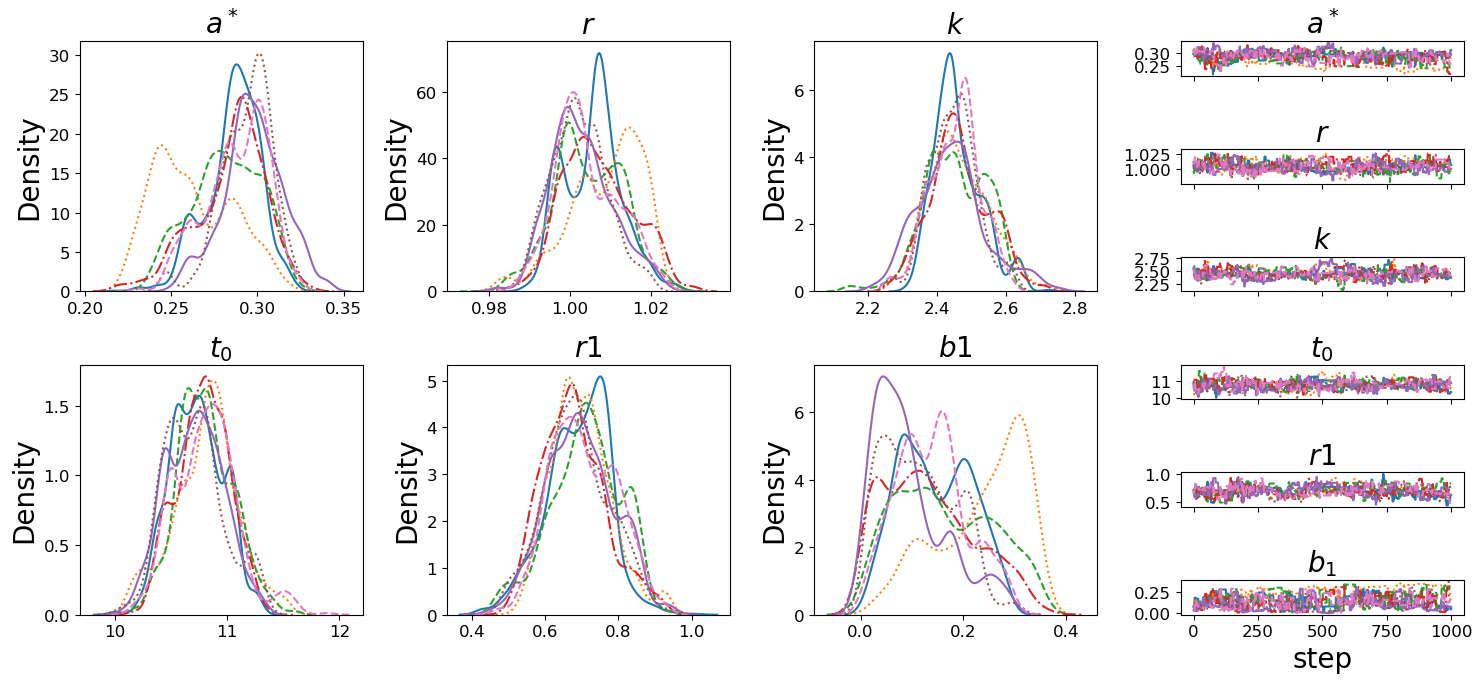

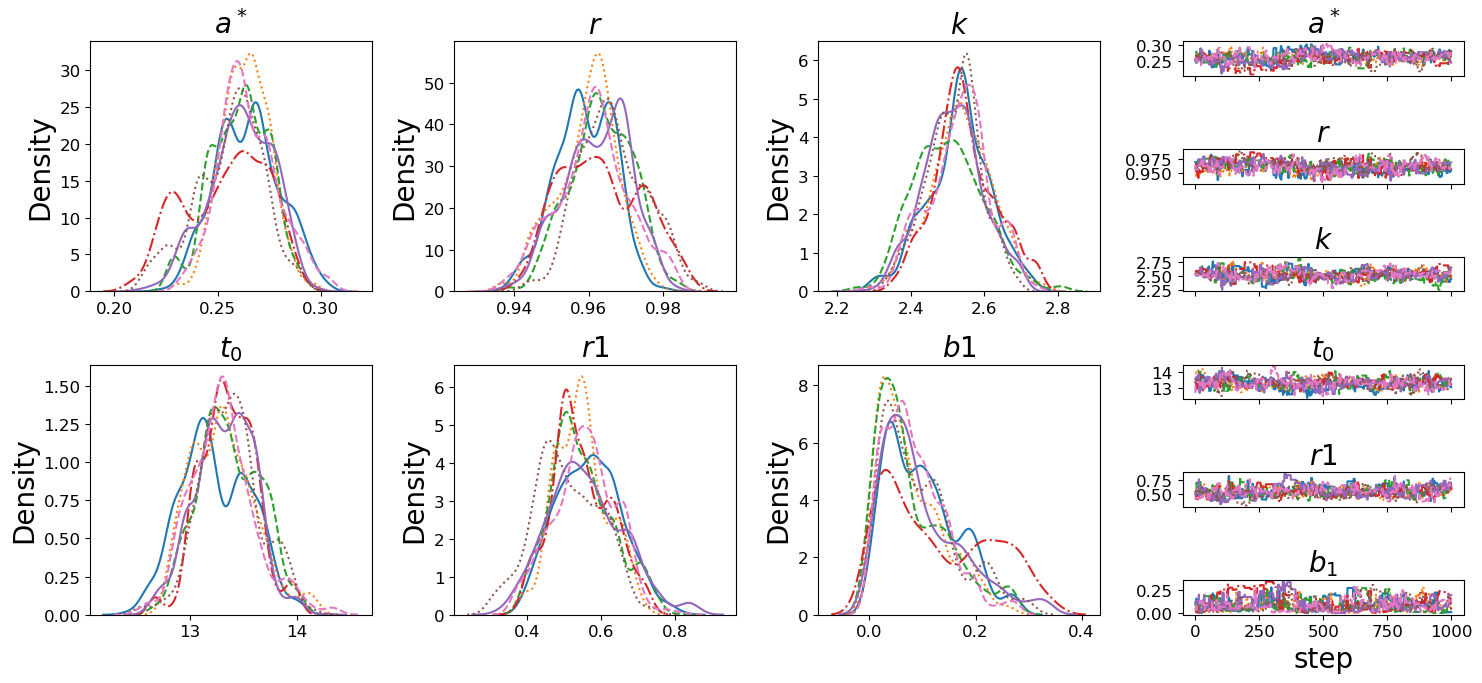

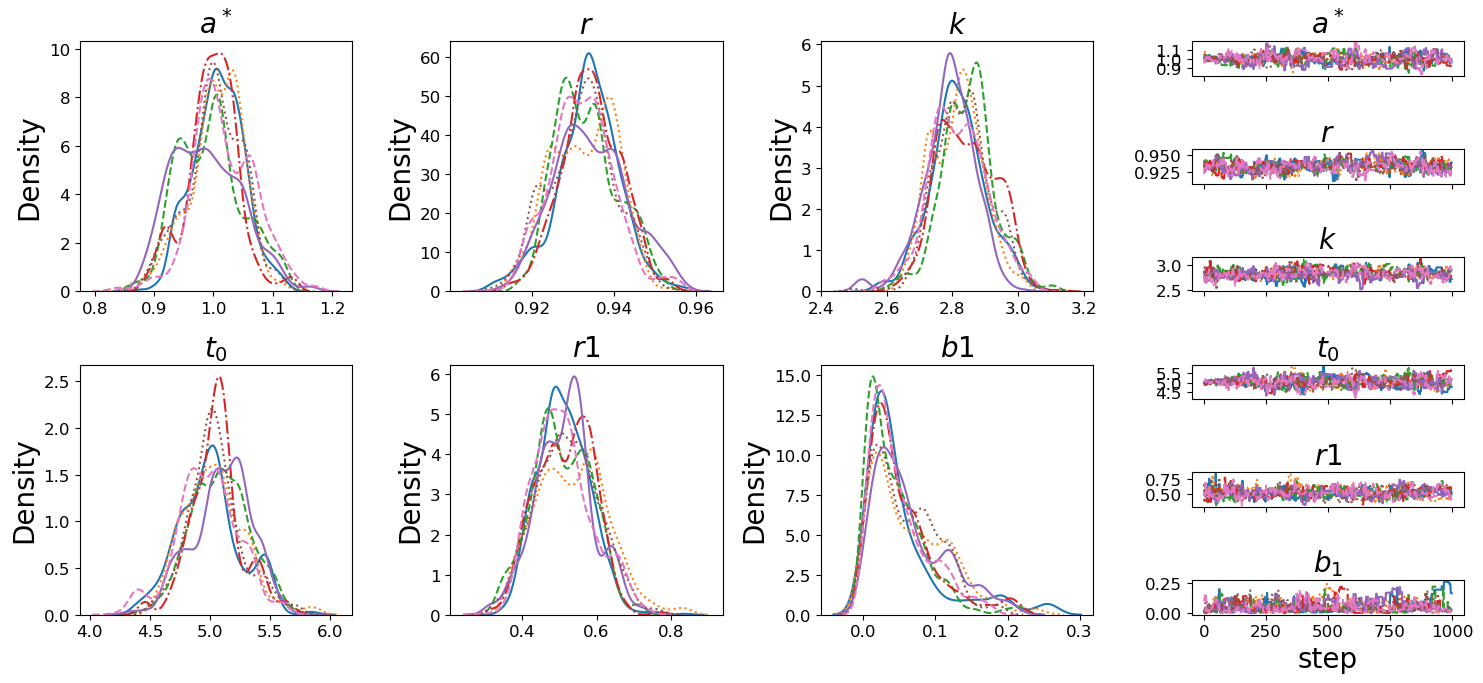

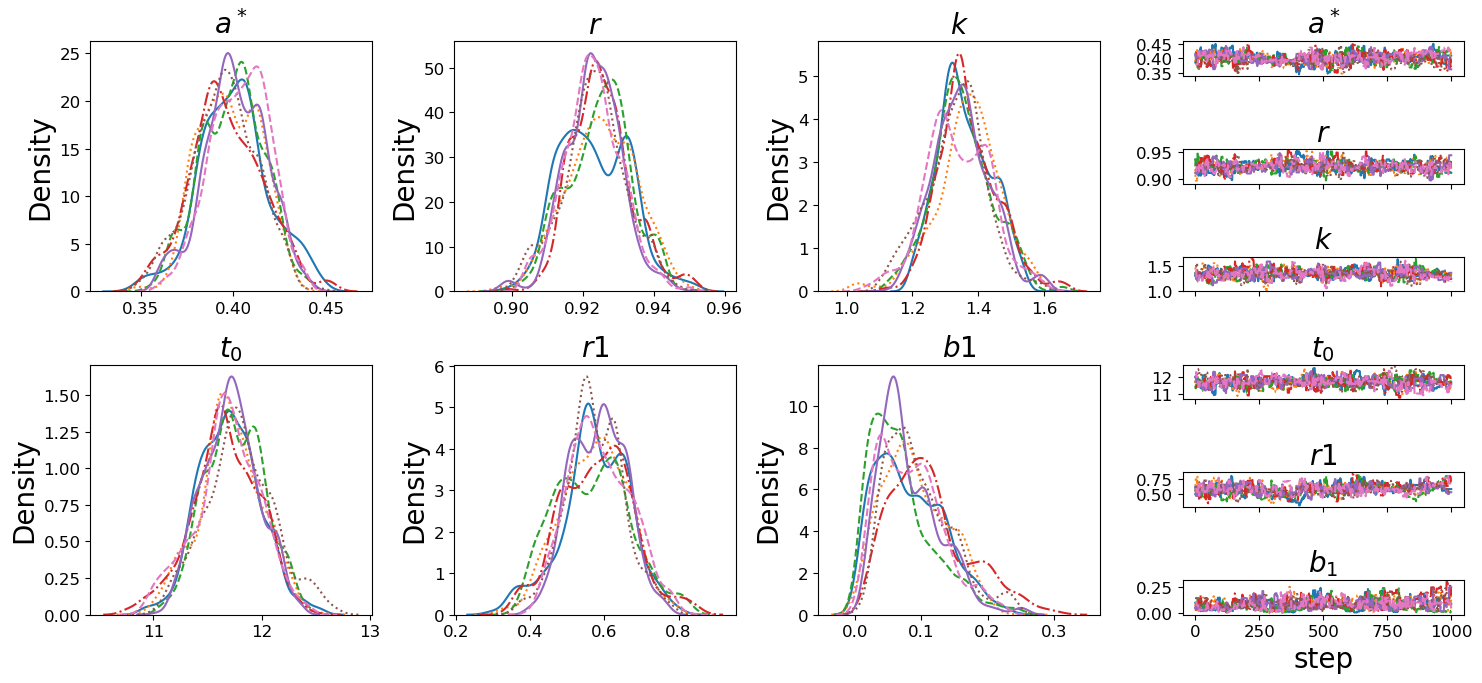

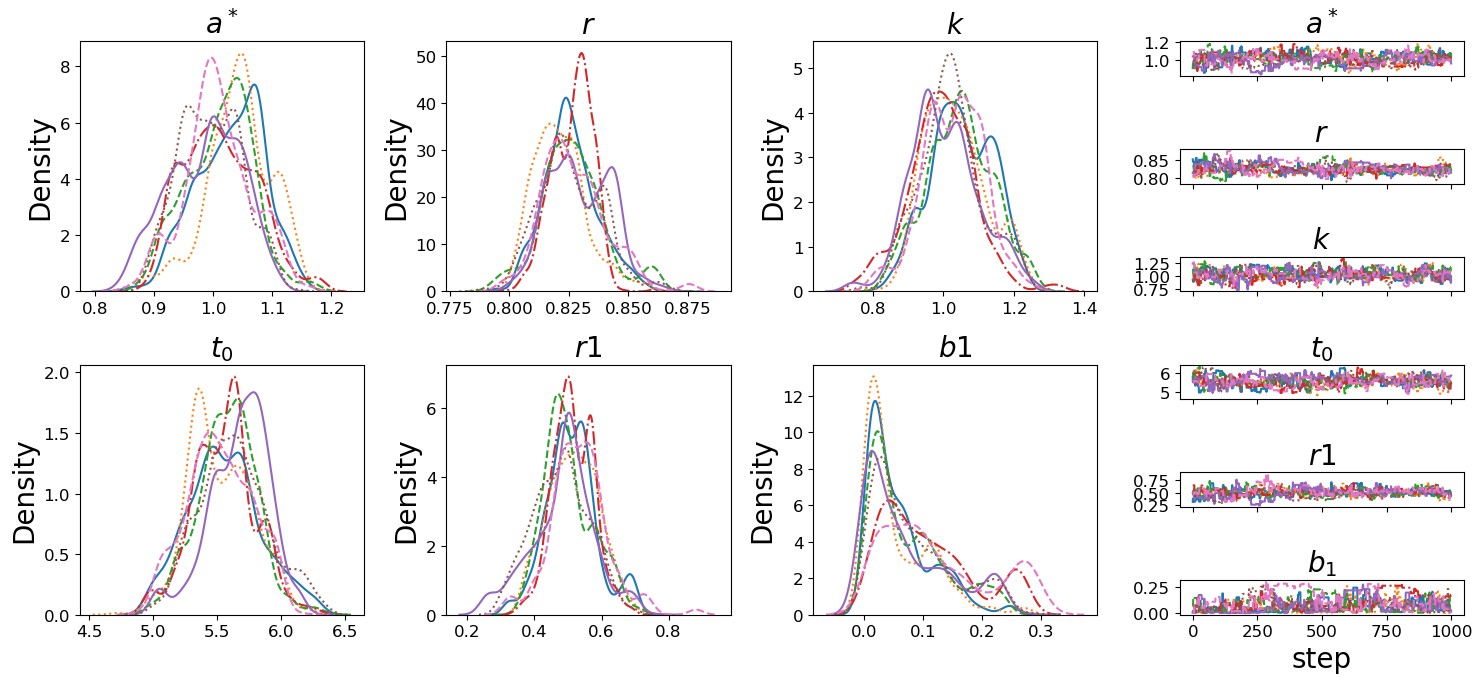

In [48]:
for donor in ages.keys():
    idata = pickle.load(open(f'../results/hsc/{donor}.pkl', 'rb'))
    fig = plt.figure(figsize=(15,7))
    plt.rcParams['font.size'] = 12
    # gt = [0.32, 1, 1.3, 0.8, 8, 0.2]
    gs = GridSpec(6, 4, figure=fig)
    ls = 'solid.dotted.dashed.dashdot.solid.dotted.dashed'.split('.')
    for ind, sym in enumerate('ax,r,k,t0,r1,b1'.split(',')):
        if ind >= 3:
            ax = fig.add_subplot(gs[3:, ind-3])
        else:
            ax = fig.add_subplot(gs[:3, ind])
        for i, l in enumerate(ls):   
            sns.kdeplot(idata.posterior[sym].to_numpy()[i], linestyle=l, ax=ax, label=f'Chain {i+1}')
        # ax1.legend(fontsize=10,loc=2)
        ylim = ax.get_ylim()
        # ax.vlines(gt[ind], *ylim, color='black')
        ax.set_ylim(ylim)
        ax.set_title(fr"${sym.replace('ax', 'a^*').replace('t0', 't_0')}$", fontsize=20)
        ax.set_ylabel('Density', fontsize=20)
    ax0 = fig.add_subplot(gs[-1, 3])
    for i, l in enumerate(ls): 
        ax0.plot(idata.posterior['b1'][i], linestyle=l, label=f'Chain {i+1}')
        ax0.set_title(fr'$b_1$', fontsize=20)
    for ind, sym in enumerate('ax,r,k,t0,r1'.split(',')):
        ax = fig.add_subplot(gs[ind, 3], sharex=ax0)
        for i, l in enumerate(ls): 
            ax.plot(idata.posterior[sym][i], linestyle=l, label=f'Chain {i+1}')
            ax.set_title(fr"${sym.replace('ax', 'a^*').replace('t0', 't_0')}$", fontsize=20)
        plt.setp(ax.get_xticklabels(), visible=False)
    ax0.set_xlabel('step', fontsize=20)
    plt.tight_layout()
    plt.savefig(f'../results/figs/{donor}_mcmc.pdf')
